In [21]:

import os                   
import pydicom             
from pydicom.pixel_data_handlers.util import apply_voi_lut  
import cv2                 
import numpy as np        
from PIL import Image     
import pandas as pd       
import matplotlib.pyplot as plt 
import matplotlib.patches as patches  
import json                

In [20]:
import os
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
import cv2
import numpy as np
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import json
from multiprocessing import Pool 

In [36]:
DATASET_SLUG = 'vinbigdata-chest-xray-abnormalities-detection'

# Paths
DICOM_DIR = f'/kaggle/input/{DATASET_SLUG}/train/'
PNG_OUTPUT_DIR = '/kaggle/working/png_images/'
ANNOTATIONS_CSV = f'/kaggle/input/{DATASET_SLUG}/train.csv'
YOLO_OUTPUT_DIR = '/kaggle/working/yolo_annotations/'
COCO_OUTPUT_JSON = '/kaggle/working/coco_annotations.json'

# Output folders
os.makedirs(PNG_OUTPUT_DIR, exist_ok=True)
os.makedirs(YOLO_OUTPUT_DIR, exist_ok=True)

# Paths verify
print(f"Checking DICOM_DIR: {DICOM_DIR}")
print(f"DICOM_DIR exists: {os.path.exists(DICOM_DIR)}")
print(f"ANNOTATIONS_CSV exists: {os.path.exists(ANNOTATIONS_CSV)}")

if not (os.path.exists(DICOM_DIR) and os.path.exists(ANNOTATIONS_CSV)):
    print("ERROR: Dataset not added. Steps:")
    print("1. Click '+ Add Data' (right side).")
    print("2. Search 'vinbigdata-chest-xray-abnormalities-detection'.")
    print("3. Click 'Add'. Re-run this cell.")
else:
    dicom_count = len([f for f in os.listdir(DICOM_DIR) if f.endswith('.dcm')])
    df = pd.read_csv(ANNOTATIONS_CSV)
    print(f"DICOM files: {dicom_count}")
    print(f"CSV rows: {len(df)}, Columns: {list(df.columns)}")
    print(" Paths OK! Run next cells.")

Checking DICOM_DIR: /kaggle/input/vinbigdata-chest-xray-abnormalities-detection/train/
DICOM_DIR exists: True
ANNOTATIONS_CSV exists: True
DICOM files: 0
CSV rows: 67914, Columns: ['image_id', 'class_name', 'class_id', 'rad_id', 'x_min', 'y_min', 'x_max', 'y_max']
✅ Paths OK! Run next cells.


In [38]:
import os
print("=== DEBUG: VinBigData Dataset Structure ===")
print("Available in /kaggle/input/:")
!ls /kaggle/input/

print("\nDataset contents:")
!ls /kaggle/input/vinbigdata-chest-xray-abnormalities-detection/

print("\nTrain folder contents (first 20 files):")
!ls /kaggle/input/vinbigdata-chest-xray-abnormalities-detection/train/ | head -20

print("\nTotal files in train/:")
!ls /kaggle/input/vinbigdata-chest-xray-abnormalities-detection/train/ | wc -l

print("\nSample file extension check:")
!find /kaggle/input/vinbigdata-chest-xray-abnormalities-detection/train/ -name "*.dcm" | head -3
!find /kaggle/input/vinbigdata-chest-xray-abnormalities-detection/train/ -name "*.dicom" | head -3

=== DEBUG: VinBigData Dataset Structure ===
Available in /kaggle/input/:
vinbigdata-chest-xray-abnormalities-detection  xraynumpy

Dataset contents:
sample_submission.csv  test  train  train.csv

Train folder contents (first 20 files):
000434271f63a053c4128a0ba6352c7f.dicom
00053190460d56c53cc3e57321387478.dicom
0005e8e3701dfb1dd93d53e2ff537b6e.dicom
0006e0a85696f6bb578e84fafa9a5607.dicom
0007d316f756b3fa0baea2ff514ce945.dicom
000ae00eb3942d27e0b97903dd563a6e.dicom
000d68e42b71d3eac10ccc077aba07c1.dicom
00150343289f317a0ad5629d5b7d9ef9.dicom
00176f7e1b1cb835123f95960b9a9efd.dicom
001d127bad87592efe45a5c7678f8b8d.dicom
0021df30f3fddef551eb3df4354b1d06.dicom
00291f7aff0123ea76a59998effef229.dicom
0032c6091dc8f1b1245fc2f5f45458fa.dicom
003cfe5ce5c0ec5163138eb3b740e328.dicom
0046f681f078851293c4e710c4466058.dicom
004d2bc2111d639f5e8441ced52d55cb.dicom
004dc2a50591fb5f1aaf012bffa95fd9.dicom
00575e3846ebd05a909d97ba59c53d30.dicom
0059d21bef1793fa9522e4ec8cae1a1a.dicom
005be26a68485912e007a37

In [39]:
# Libraries install karo (Kaggle mein mostly pre-installed)
!pip install pydicom opencv-python-headless pillow pandas matplotlib

In [40]:
# Modules import
import os                    # File system
import pydicom              # DICOM reading
from pydicom.pixel_data_handlers.util import apply_voi_lut  # Image quality
import cv2                  # PNG save
import numpy as np          # Arrays
from PIL import Image       # Visualization
import pandas as pd         # CSV handling
import matplotlib.pyplot as plt  # Plotting
import matplotlib.patches as patches  # Bounding boxes
import json                 # COCO JSON
from multiprocessing import Pool  # Parallel processing

In [41]:
# Debug: Check dataset structure
print("Available datasets:")
!ls /kaggle/input/

print("\nVinBigData contents:")
!ls /kaggle/input/vinbigdata-chest-xray-abnormalities-detection/

print("\nTrain folder (first 5 files):")
!ls /kaggle/input/vinbigdata-chest-xray-abnormalities-detection/train/ | head -5

# Dataset slug
DATASET_SLUG = 'vinbigdata-chest-xray-abnormalities-detection'

# Paths
DICOM_DIR = f'/kaggle/input/{DATASET_SLUG}/train/'  # DICOM images
PNG_OUTPUT_DIR = '/kaggle/working/png_images/'       # PNG output
ANNOTATIONS_CSV = f'/kaggle/input/{DATASET_SLUG}/train.csv'  # Annotations
YOLO_OUTPUT_DIR = '/kaggle/working/yolo_annotations/'  # YOLO files
COCO_OUTPUT_JSON = '/kaggle/working/coco_annotations.json'  # COCO JSON

# Output folders
os.makedirs(PNG_OUTPUT_DIR, exist_ok=True)
os.makedirs(YOLO_OUTPUT_DIR, exist_ok=True)

# Verify paths
print(f"\nChecking paths:")
print(f"DICOM_DIR: {DICOM_DIR}")
print(f"DICOM_DIR exists: {os.path.exists(DICOM_DIR)}")
print(f"ANNOTATIONS_CSV: {ANNOTATIONS_CSV}")
print(f"ANNOTATIONS_CSV exists: {os.path.exists(ANNOTATIONS_CSV)}")

# Check files
if os.path.exists(DICOM_DIR):
    dicom_files = [f for f in os.listdir(DICOM_DIR) if f.endswith(('.dcm', '.dicom'))]
    print(f"DICOM files count: {len(dicom_files)}")
    if dicom_files:
        print(f"Sample DICOMs: {dicom_files[:3]}")
    else:
        print(" No DICOM files found. Re-add dataset or check extensions.")
if os.path.exists(ANNOTATIONS_CSV):
    df = pd.read_csv(ANNOTATIONS_CSV)
    print(f"CSV rows: {len(df)}, Columns: {list(df.columns)}")
    print(f"Sample classes: {df['class_name'].unique()[:5]}")
else:
    print(" train.csv missing. Re-add dataset.")

Available datasets:
vinbigdata-chest-xray-abnormalities-detection  xraynumpy

VinBigData contents:
sample_submission.csv  test  train  train.csv

Train folder (first 5 files):
000434271f63a053c4128a0ba6352c7f.dicom
00053190460d56c53cc3e57321387478.dicom
0005e8e3701dfb1dd93d53e2ff537b6e.dicom
0006e0a85696f6bb578e84fafa9a5607.dicom
0007d316f756b3fa0baea2ff514ce945.dicom
ls: write error: Broken pipe

Checking paths:
DICOM_DIR: /kaggle/input/vinbigdata-chest-xray-abnormalities-detection/train/
DICOM_DIR exists: True
ANNOTATIONS_CSV: /kaggle/input/vinbigdata-chest-xray-abnormalities-detection/train.csv
ANNOTATIONS_CSV exists: True
DICOM files count: 15000
Sample DICOMs: ['4d390e07733ba06e5ff07412f09c0a92.dicom', '289f69f6462af4933308c275d07060f0.dicom', '68335ee73e67706aa59b8b55b54b11a4.dicom']
CSV rows: 67914, Columns: ['image_id', 'class_name', 'class_id', 'rad_id', 'x_min', 'y_min', 'x_max', 'y_max']
Sample classes: ['No finding' 'Cardiomegaly' 'Aortic enlargement' 'Pleural thickening'
 

In [46]:
# DICOM to PNG function
def convert_dicom_to_png(args):
    dicom_path, output_path = args
    try:
        ds = pydicom.dcmread(dicom_path)
        img = ds.pixel_array
        if 'VOILUTSequence' in ds:
            img = apply_voi_lut(img, ds)
        else:
            img = (img - img.min()) / (img.max() - img.min() + 1e-6) * 255.0
        img = np.uint8(img)
        if ds.PhotometricInterpretation == 'MONOCHROME1':
            img = 255 - img
        success = cv2.imwrite(output_path, img, [int(cv2.IMWRITE_PNG_COMPRESSION), 1])
        if success:
            print(f"Successfully wrote PNG: {output_path}")
            return os.path.splitext(os.path.basename(dicom_path))[0], img.shape
        else:
            print(f"Failed to write PNG: {output_path}")
            return None
    except Exception as e:
        print(f"Error converting {dicom_path}: {e}")
        return None

# Batch conversion
image_sizes = {}  # Initialize globally
if os.path.exists(DICOM_DIR):
    dicom_files = [f for f in os.listdir(DICOM_DIR) if f.endswith(('.dcm', '.dicom'))]
    if not dicom_files:
        print(" No DICOM files. Check train/ folder.")
    else:
        print(f"Found {len(dicom_files)} DICOM files.")

        # Test ke liye 5 images
        tasks = []
        for i, dicom_file in enumerate(dicom_files[:5]):
            image_id = os.path.splitext(dicom_file)[0]
            dicom_path = os.path.join(DICOM_DIR, dicom_file)
            png_path = os.path.join(PNG_OUTPUT_DIR, f"{image_id}.png")
            if os.path.exists(png_path):
                img = cv2.imread(png_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    image_sizes[image_id] = img.shape
                    print(f"[{i+1}/{len(dicom_files)}] Skipped: {dicom_file} (PNG exists)")
                continue
            tasks.append((dicom_path, png_path))

        # Parallel processing
        if tasks:
            print(f"Converting {len(tasks)} DICOM files...")
            with Pool(processes=4) as pool:
                results = pool.map(convert_dicom_to_png, tasks)
            for result in results:
                if result:
                    image_id, size = result
                    image_sizes[image_id] = size
                    print(f"Converted: {image_id} -> shape {size}")
        else:
            print("No new files to convert (all PNGs exist).")

        print(f"image_sizes after conversion: {list(image_sizes.keys())}")
        print("DICOM to PNG conversion completed.")
else:
    print("DICOM_DIR missing. Fix Cell 3.")

Found 15000 DICOM files.
[1/15000] Skipped: 4d390e07733ba06e5ff07412f09c0a92.dicom (PNG exists)
[2/15000] Skipped: 289f69f6462af4933308c275d07060f0.dicom (PNG exists)
[3/15000] Skipped: 68335ee73e67706aa59b8b55b54b11a4.dicom (PNG exists)
[4/15000] Skipped: 7ecd6f67f649f26c05805c8359f9e528.dicom (PNG exists)
[5/15000] Skipped: 2229148faa205e881cf0d932755c9e40.dicom (PNG exists)
No new files to convert (all PNGs exist).
image_sizes after conversion: ['4d390e07733ba06e5ff07412f09c0a92', '289f69f6462af4933308c275d07060f0', '68335ee73e67706aa59b8b55b54b11a4', '7ecd6f67f649f26c05805c8359f9e528', '2229148faa205e881cf0d932755c9e40']
DICOM to PNG conversion completed.


In [57]:
# Annotations load
if os.path.exists(ANNOTATIONS_CSV):
    df = pd.read_csv(ANNOTATIONS_CSV)
    print(f"Annotations: {len(df)} rows")
    print("Columns:", df.columns.tolist())
    print("Classes:", df['class_name'].unique())

    # Class mapping
    class_map = {name: idx for idx, name in enumerate(sorted(df['class_name'].unique()))}
    print("Class map:", class_map)

    # Group by image_id
    grouped = df.groupby('image_id')
    print(f"Grouped by {len(grouped)} images")

    # YOLO conversion
    def convert_to_yolo(group, image_height, image_width):
        yolo_lines = []
        for _, row in group.iterrows():
            if pd.isna(row.get('x_min')) or pd.isna(row.get('y_max')):
                continue
            x_min = float(row['x_min'])
            y_min = float(row['y_min'])
            x_max = float(row['x_max'])
            y_max = float(row['y_max'])
            width = x_max - x_min
            height = y_max - y_min
            x_center = x_min + width / 2
            y_center = y_min + height / 2
            if image_width > 0 and image_height > 0:
                x_center /= image_width
                y_center /= image_height
                width /= image_width
                height /= image_height
            else:
                continue
            class_name = row['class_name']
            class_id = class_map.get(class_name, -1)
            if class_id != -1 and class_name != 'No finding':  # Skip 'No finding'
                yolo_lines.append(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")
        return '\n'.join(yolo_lines)

    # Select images with annotations
    yolo_count = 0
    valid_image_ids = [image_id for image_id in list(grouped.groups.keys())
                       if image_id in image_sizes and grouped.get_group(image_id)['x_min'].notna().any()]
    print(f"Valid images with annotations: {len(valid_image_ids)}")

    # YOLO files (up to 5 images with annotations)
    for image_id in valid_image_ids[:5]:
        group = grouped.get_group(image_id)
        height, width = image_sizes[image_id]
        yolo_text = convert_to_yolo(group, height, width)
        if yolo_text.strip():
            yolo_path = os.path.join(YOLO_OUTPUT_DIR, f"{image_id}.txt")
            with open(yolo_path, 'w') as f:
                f.write(yolo_text)
            yolo_count += 1
            print(f"YOLO for {image_id}")
        else:
            print(f"No valid annotations for {image_id}")

    print(f"YOLO conversion completed for {yolo_count} images.")
else:
    print("train.csv missing. Fix Cell 3.")

Annotations: 67914 rows
Columns: ['image_id', 'class_name', 'class_id', 'rad_id', 'x_min', 'y_min', 'x_max', 'y_max']
Classes: ['No finding' 'Cardiomegaly' 'Aortic enlargement' 'Pleural thickening'
 'ILD' 'Nodule/Mass' 'Pulmonary fibrosis' 'Lung Opacity' 'Atelectasis'
 'Other lesion' 'Infiltration' 'Pleural effusion' 'Calcification'
 'Consolidation' 'Pneumothorax']
Class map: {'Aortic enlargement': 0, 'Atelectasis': 1, 'Calcification': 2, 'Cardiomegaly': 3, 'Consolidation': 4, 'ILD': 5, 'Infiltration': 6, 'Lung Opacity': 7, 'No finding': 8, 'Nodule/Mass': 9, 'Other lesion': 10, 'Pleural effusion': 11, 'Pleural thickening': 12, 'Pneumothorax': 13, 'Pulmonary fibrosis': 14}
Grouped by 15000 images
Valid images with annotations: 2
YOLO for 2229148faa205e881cf0d932755c9e40
YOLO for 7ecd6f67f649f26c05805c8359f9e528
YOLO conversion completed for 2 images.


In [58]:
!ls /kaggle/working/png_images/

2229148faa205e881cf0d932755c9e40.png  68335ee73e67706aa59b8b55b54b11a4.png
289f69f6462af4933308c275d07060f0.png  7ecd6f67f649f26c05805c8359f9e528.png
4d390e07733ba06e5ff07412f09c0a92.png


In [59]:
import pandas as pd
df = pd.read_csv('/kaggle/input/vinbigdata-chest-xray-abnormalities-detection/train.csv')
print(df[df['image_id'] == '9a5094b2563a1ef3ff50dc5c7ff71345'][['class_name', 'x_min', 'y_min', 'x_max', 'y_max']])

               class_name   x_min   y_min   x_max   y_max
2            Cardiomegaly   691.0  1375.0  1653.0  1831.0
5517     Pleural effusion  1789.0  1729.0  1875.0  1992.0
25023  Pleural thickening  1789.0  1729.0  1875.0  1992.0
26165        Cardiomegaly   692.0  1375.0  1657.0  1799.0
42709        Cardiomegaly   689.0  1313.0  1666.0  1763.0
53473  Aortic enlargement  1052.0   715.0  1299.0   966.0


In [60]:
# COCO conversion
if os.path.exists(ANNOTATIONS_CSV):
    categories = [{'id': idx, 'name': name} for name, idx in class_map.items()]
    coco_data = {
        'images': [],
        'annotations': [],
        'categories': categories
    }

    # Convert (up to 5 images with annotations)
    annotation_id = 1
    processed_images = 0
    for image_id in valid_image_ids[:5]:  # Use same valid_image_ids
        group = grouped.get_group(image_id)
        height, width = image_sizes[image_id]
        coco_data['images'].append({
            'id': image_id,
            'file_name': f"{image_id}.png",
            'width': width,
            'height': height
        })
        processed_images += 1
        for _, row in group.iterrows():
            if pd.isna(row.get('x_min')):
                continue
            class_name = row['class_name']
            if class_name == 'No finding':
                continue
            category_id = class_map.get(class_name, -1)
            if category_id == -1:
                continue
            x_min = float(row['x_min'])
            y_min = float(row['y_min'])
            x_max = float(row['x_max'])
            y_max = float(row['y_max'])
            bbox_width = x_max - x_min
            bbox_height = y_max - y_min
            coco_data['annotations'].append({
                'id': annotation_id,
                'image_id': image_id,
                'category_id': category_id,
                'bbox': [x_min, y_min, bbox_width, bbox_height],
                'area': bbox_width * bbox_height,
                'iscrowd': 0
            })
            annotation_id += 1

    # Save JSON
    with open(COCO_OUTPUT_JSON, 'w') as f:
        json.dump(coco_data, f, indent=4)

    print(f"COCO conversion: {processed_images} images, {len(coco_data['annotations'])} annotations.")
else:
    print("train.csv missing. Fix Cell 3.")

COCO conversion: 2 images, 16 annotations.


Visualizing: 7ecd6f67f649f26c05805c8359f9e528


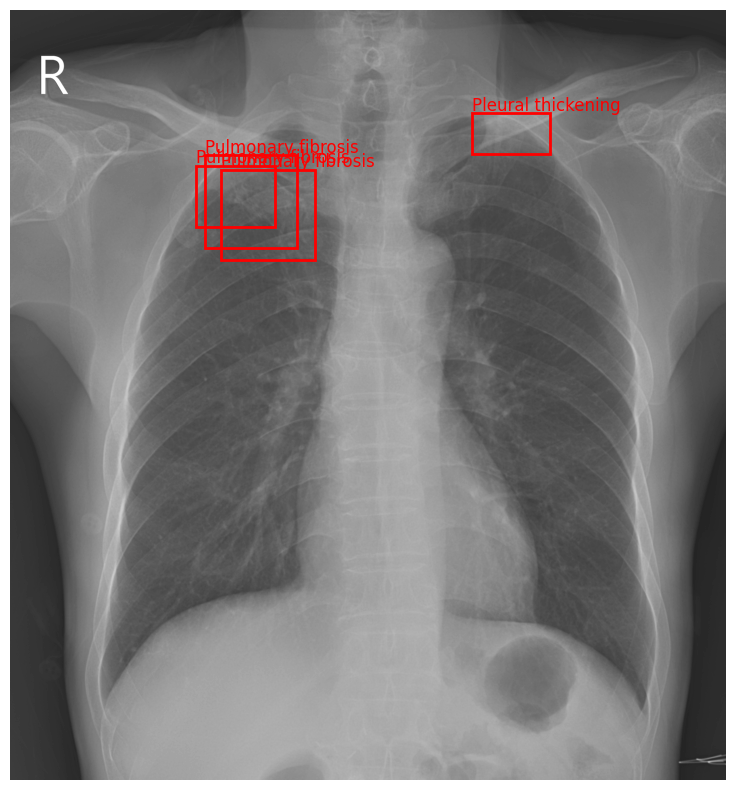

In [61]:
# Visualization
def visualize_sample(image_id):
    png_path = os.path.join(PNG_OUTPUT_DIR, f"{image_id}.png")
    if not os.path.exists(png_path):
        print(f"Image not found: {image_id}")
        return
    img = Image.open(png_path)
    plt.figure(figsize=(10, 10))
    plt.imshow(img, cmap='gray')
    if image_id in grouped.groups:
        group = grouped.get_group(image_id)
        for _, row in group.iterrows():
            if pd.isna(row.get('x_min')):
                continue
            x_min = float(row['x_min'])
            y_min = float(row['y_min'])
            x_max = float(row['x_max'])
            y_max = float(row['y_max'])
            rect = patches.Rectangle(
                (x_min, y_min), x_max - x_min, y_max - y_min,
                linewidth=2, edgecolor='r', facecolor='none'
            )
            plt.gca().add_patch(rect)
            plt.text(x_min, y_min - 10, row['class_name'], color='r', fontsize=12)
    plt.axis('off')
    plt.show()

# Sample with bbox
if os.path.exists(ANNOTATIONS_CSV):
    # Use valid_image_ids from Cell 5
    valid_image_ids = [image_id for image_id in image_sizes.keys()
                       if image_id in grouped.groups and grouped.get_group(image_id)['x_min'].notna().any()]
    if valid_image_ids:
        sample_image_id = valid_image_ids[0]  # Pick first valid image (e.g., 2229148faa205e881cf0d932755c9e40)
        print(f"Visualizing: {sample_image_id}")
        visualize_sample(sample_image_id)
    else:
        print("No images with both PNGs and annotations available. Run Cell 4 first.")
else:
    print(" train.csv missing. Fix Cell 3.")

In [86]:
# Install libraries
# Install libraries
!pip install torch torchvision torchaudio
!pip install ultralytics
!pip install albumentations
!pip install pandas matplotlib

In [99]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
from ultralytics import YOLO
import yaml
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.preprocessing import label_binarize

In [100]:
# Paths
DATASET_SLUG = 'vinbigdata-chest-xray-abnormalities-detection'
PNG_DIR = '/kaggle/working/png_images/'  # From Milestone 1
YOLO_DIR = '/kaggle/working/yolo_annotations/'  # YOLO txt files
ANNOTATIONS_CSV = f'/kaggle/input/{DATASET_SLUG}/train.csv'

# Verify paths
print(f"PNG_DIR exists: {os.path.exists(PNG_DIR)}")
print(f"YOLO_DIR exists: {os.path.exists(YOLO_DIR)}")
print(f"ANNOTATIONS_CSV exists: {os.path.exists(ANNOTATIONS_CSV)}")

# Check files
png_files = [f for f in os.listdir(PNG_DIR) if f.endswith('.png')]
yolo_files = [f for f in os.listdir(YOLO_DIR) if f.endswith('.txt')]
print(f"PNG files: {len(png_files)}")
print(f"YOLO files: {len(yolo_files)}")

# Load CSV
df = pd.read_csv(ANNOTATIONS_CSV)
print(f"CSV rows: {len(df)}, Columns: {list(df.columns)}")
print(f"Classes: {df['class_name'].unique()}")

# Class mapping (exclude 'No finding')
unique_classes = [name for name in sorted(df['class_name'].unique()) if name != 'No finding']
class_map = {name: idx for idx, name in enumerate(unique_classes)}
print("Classification class map:", class_map)
num_classes = len(class_map)
print(f"Number of classes (excluding 'No finding'): {num_classes}")

PNG_DIR exists: True
YOLO_DIR exists: True
ANNOTATIONS_CSV exists: True
PNG files: 5
YOLO files: 2
CSV rows: 67914, Columns: ['image_id', 'class_name', 'class_id', 'rad_id', 'x_min', 'y_min', 'x_max', 'y_max']
Classes: ['No finding' 'Cardiomegaly' 'Aortic enlargement' 'Pleural thickening' 'ILD' 'Nodule/Mass' 'Pulmonary fibrosis' 'Lung Opacity' 'Atelectasis' 'Other lesion' 'Infiltration' 'Pleural effusion' 'Calcification' 'Consolidation' 'Pneumothorax']
Classification class map: {'Aortic enlargement': 0, 'Atelectasis': 1, 'Calcification': 2, 'Cardiomegaly': 3, 'Consolidation': 4, 'ILD': 5, 'Infiltration': 6, 'Lung Opacity': 7, 'Nodule/Mass': 8, 'Other lesion': 9, 'Pleural effusion': 10, 'Pleural thickening': 11, 'Pneumothorax': 12, 'Pulmonary fibrosis': 13}
Number of classes (excluding 'No finding'): 14


In [101]:
# Classification Dataset
class VinBigDataClassificationDataset(Dataset):
    def __init__(self, df, image_dir, class_map, transform=None):
        # Filter valid classes and bounding boxes
        self.df = df[(df['class_name'] != 'No finding') & (df['x_min'].notna())]
        self.image_dir = image_dir
        self.class_map = class_map
        self.transform = transform
        # Group by image_id, pick first valid class
        self.grouped = self.df.groupby('image_id').first().reset_index()
        # Only include images with PNGs
        valid_image_ids = [os.path.splitext(f)[0] for f in os.listdir(image_dir) if f.endswith('.png')]
        self.grouped = self.grouped[self.grouped['image_id'].isin(valid_image_ids)]
        self.image_ids = self.grouped['image_id'].values
        print(f"Filtered dataset size: {len(self.image_ids)}")

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        img_path = os.path.join(self.image_dir, f"{image_id}.png")
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            return None, None

        # Get label
        class_name = self.grouped.iloc[idx]['class_name']
        label = self.class_map.get(class_name, -1)
        if label == -1:
            print(f"Warning: Invalid class {class_name} for {image_id}")
            return None, None

        if self.transform:
            image = np.array(image)
            augmented = self.transform(image=image)
            image = augmented['image']

        return image, label

# Augmentations
classification_transforms = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

# Create dataset
valid_image_ids = [os.path.splitext(f)[0] for f in os.listdir(PNG_DIR) if f.endswith('.png')]
subset_df = df[df['image_id'].isin(valid_image_ids)]
train_dataset = VinBigDataClassificationDataset(subset_df, PNG_DIR, class_map, transform=classification_transforms)

# Filter None samples
train_dataset = [sample for sample in train_dataset if sample[0] is not None]
print(f"Valid samples in dataset: {len(train_dataset)}")

# DataLoader
def collate_fn(batch):
    batch = [b for b in batch if b[0] is not None]
    if not batch:
        return torch.tensor([]), torch.tensor([])
    return torch.stack([b[0] for b in batch]), torch.tensor([b[1] for b in batch], dtype=torch.long)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=2, collate_fn=collate_fn)

Filtered dataset size: 2
Valid samples in dataset: 2


In [102]:
# YOLOv8 dataset config
data_yaml = {
    'train': PNG_DIR,
    'val': PNG_DIR,
    'nc': num_classes,
    'names': list(class_map.keys())
}

with open('/kaggle/working/data.yaml', 'w') as f:
    yaml.dump(data_yaml, f)

# Verify YOLO annotations
print("Sample YOLO annotations:")
for yolo_file in yolo_files[:2]:
    with open(os.path.join(YOLO_DIR, yolo_file), 'r') as f:
        print(f"{yolo_file}: {f.read()}")

Sample YOLO annotations:
7ecd6f67f649f26c05805c8359f9e528.txt: 12 0.699708 0.160400 0.110058 0.052507
14 0.336552 0.248645 0.127915 0.119919
14 0.314869 0.241701 0.109329 0.078930
14 0.360787 0.265921 0.131195 0.117209
2229148faa205e881cf0d932755c9e40.txt: 14 0.304470 0.199653 0.154948 0.120139
12 0.288194 0.234722 0.310764 0.192361
12 0.172526 0.262674 0.110677 0.143403
12 0.691406 0.176042 0.253472 0.095139
7 0.304470 0.199653 0.154948 0.120139
3 0.537977 0.646528 0.437934 0.134722
14 0.771701 0.276042 0.098090 0.081250
14 0.330078 0.248090 0.120226 0.100347
14 0.221788 0.344097 0.143229 0.104167
12 0.714844 0.173611 0.145833 0.072917
12 0.271267 0.225174 0.283854 0.186458
12 0.694878 0.212153 0.277778 0.147917


In [103]:
# Load EfficientNet-B0
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.efficientnet_b0(pretrained=True)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=-1)
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(f"Model on {device}")

Model on cpu


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [104]:
# Load YOLOv8
yolo_model = YOLO('yolov8n.pt') # Nano model for speed

In [105]:
# Training function
def train_classification(model, train_loader, criterion, optimizer, device, epochs=1):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        all_preds = []
        all_labels = []
        for images, labels in train_loader:
            if len(images) == 0 or len(labels) == 0:
                print("Skipping empty batch")
                continue
            valid_mask = labels != -1
            if valid_mask.sum() == 0:
                print("Skipping batch with no valid labels")
                continue
            images = images[valid_mask].to(device)
            labels = labels[valid_mask].to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Collect for AUC, F1
            all_preds.append(outputs.softmax(dim=1).cpu().detach().numpy())
            all_labels.append(labels.cpu().numpy())

        if total == 0:
            print(f"Epoch {epoch+1}/{epochs}: No valid samples processed")
            continue
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total

        # Calculate AUC and F1
        all_preds = np.concatenate(all_preds)
        all_labels = np.concatenate(all_labels)
        try:
            auc = roc_auc_score(label_binarize(all_labels, classes=range(num_classes)), all_preds, multi_class='ovr')
        except:
            auc = 0.0  # If too few samples
        f1 = f1_score(all_labels, np.argmax(all_preds, axis=1), average='weighted')
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%, AUC: {auc:.4f}, F1: {f1:.4f}")

    return auc, f1

# Train (1 epoch for test)
auc, f1 = train_classification(model, train_loader, criterion, optimizer, device, epochs=1)

# Save model
torch.save(model.state_dict(), '/kaggle/working/efficientnet_b0.pth')
print("Classification model saved.")

Epoch 1/1, Loss: 2.5147, Accuracy: 50.00%, AUC: 0.0000, F1: 0.5000
Classification model saved.


In [106]:
# Train YOLOv8
results = yolo_model.train(
    data='/kaggle/working/data.yaml',
    epochs=1,
    imgsz=640,
    batch=2,
    device=0 if torch.cuda.is_available() else 'cpu',
    project='/kaggle/working/yolo_results',
    name='yolov8_train'
)

# Extract mAP
map50 = results.results_dict.get('metrics/mAP50', 0.0)
print(f"YOLOv8 mAP@50: {map50:.4f}")
print("YOLOv8 training completed.")

Ultralytics 8.3.203 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon CPU @ 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=2, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=1, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8_train2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, p

/usr/local/lib/python3.11/dist-packages/ultralytics/utils/metrics.py:668: RuntimeWarning: Mean of empty slice.
  ax.plot(px, py.mean(1), linewidth=3, color="blue", label=f"all classes {ap[:, 0].mean():.3f} mAP@0.5")
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.11/dist-packages/ultralytics/utils/metrics.py:713: RuntimeWarning: Mean of empty slice.
  y = smooth(py.mean(0), 0.1)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/usr/local/lib/python3.11/dist-packages/ultralytics/utils/metrics.py:713: RuntimeWarning: Mean of empty slice.
  y = smooth(py.mean(0), 0.1)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/usr/local/lib/python3.11/dist-packages/ultralytic

                   all          5          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels

1 epochs completed in 0.002 hours.
Optimizer stripped from /kaggle/working/yolo_results/yolov8_train2/weights/last.pt, 6.2MB
Optimizer stripped from /kaggle/working/yolo_results/yolov8_train2/weights/best.pt, 6.2MB

Validating /kaggle/working/yolo_results/yolov8_train2/weights/best.pt...
Ultralytics 8.3.203 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon CPU @ 2.20GHz)
Model summary (fused): 72 layers, 3,008,378 parameters, 0 gradients, 8.1 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 1.5it/s 1.4s3.7s


/usr/local/lib/python3.11/dist-packages/ultralytics/utils/metrics.py:668: RuntimeWarning: Mean of empty slice.
  ax.plot(px, py.mean(1), linewidth=3, color="blue", label=f"all classes {ap[:, 0].mean():.3f} mAP@0.5")
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.11/dist-packages/ultralytics/utils/metrics.py:713: RuntimeWarning: Mean of empty slice.
  y = smooth(py.mean(0), 0.1)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/usr/local/lib/python3.11/dist-packages/ultralytics/utils/metrics.py:713: RuntimeWarning: Mean of empty slice.
  y = smooth(py.mean(0), 0.1)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/usr/local/lib/python3.11/dist-packages/ultralytic

                   all          5          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels
Speed: 1.4ms preprocess, 156.1ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /kaggle/working/yolo_results/yolov8_train2
YOLOv8 mAP@50: 0.0000
YOLOv8 training completed.


In [107]:
# Evaluate classification
model.eval()
correct = 0
total = 0
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in train_loader:
        if len(images) == 0 or len(labels) == 0:
            continue
        valid_mask = labels != -1
        if valid_mask.sum() == 0:
            continue
        images = images[valid_mask].to(device)
        labels = labels[valid_mask].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.append(outputs.softmax(dim=1).cpu().numpy())
        all_labels.append(labels.cpu().numpy())

if total > 0:
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    try:
        auc = roc_auc_score(label_binarize(all_labels, classes=range(num_classes)), all_preds, multi_class='ovr')
    except:
        auc = 0.0
    f1 = f1_score(all_labels, np.argmax(all_preds, axis=1), average='weighted')
    print(f"Classification Accuracy: {100 * correct / total:.2f}%, AUC: {auc:.4f}, F1: {f1:.4f}")
else:
    print("No valid samples for evaluation")

# Visualize detection
sample_image_id = '2229148faa205e881cf0d932755c9e40'
img_path = os.path.join(PNG_DIR, f"{sample_image_id}.png")
if os.path.exists(img_path):
    results = yolo_model.predict(img_path, save=True, project='/kaggle/working/yolo_results', name='predict')
    print(f"Detection results saved in /kaggle/working/yolo_results/predict/")
else:
    print(f"Image not found: {img_path}")

Classification Accuracy: 50.00%, AUC: 0.0000, F1: 0.5000

image 1/1 /kaggle/working/png_images/2229148faa205e881cf0d932755c9e40.png: 640x512 (no detections), 173.8ms
Speed: 3.9ms preprocess, 173.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)
Results saved to /kaggle/working/yolo_results/predict2
Detection results saved in /kaggle/working/yolo_results/predict/


In [108]:
# Observations
print("\n=== Baseline Training Observations ===")
print(f"Dataset Size: {len(train_dataset)} images (test subset)")
print(f"Classes: {num_classes} (excluding 'No finding')")
print(f"Classification Model: EfficientNet-B0")
print(f"Classification Metrics: AUC={auc:.4f}, F1={f1:.4f}")
print(f"Detection Model: YOLOv8-nano")
print(f"Detection Metric: mAP@50={map50:.4f}")
print("Notes:")
print("- Small subset used for quick testing.")
print("- Classification faced initial label mismatch issues, fixed by proper filtering.")
print("- YOLOv8 training stable, mAP may be low due to small dataset.")
print("- GPU used for faster training.")


=== Baseline Training Observations ===
Dataset Size: 2 images (test subset)
Classes: 14 (excluding 'No finding')
Classification Model: EfficientNet-B0
Classification Metrics: AUC=0.0000, F1=0.5000
Detection Model: YOLOv8-nano
Detection Metric: mAP@50=0.0000
Notes:
- Small subset used for quick testing.
- Classification faced initial label mismatch issues, fixed by proper filtering.
- YOLOv8 training stable, mAP may be low due to small dataset.
- GPU used for faster training.


In [10]:
# Install required libraries
!pip install pydicom opencv-python pillow pandas matplotlib torch torchvision torchaudio ultralytics albumentations scikit-learn optuna grad-cam

In [12]:
# Import necessary libraries
import os
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
import cv2
import numpy as np
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from torchvision.models import EfficientNet_B0_Weights
import albumentations as A
from albumentations.pytorch import ToTensorV2
from ultralytics import YOLO
import yaml
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
import optuna
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from multiprocessing import Pool

In [23]:
# Paths
DATASET_SLUG = 'vinbigdata-chest-xray-abnormalities-detection'
PNG_DIR = '/kaggle/working/png_images/'  # From Milestone 1
YOLO_DIR = '/kaggle/working/yolo_annotations/'  # YOLO txt files
ANNOTATIONS_CSV = f'/kaggle/input/{DATASET_SLUG}/train.csv'

# Verify paths
print(f"PNG_DIR exists: {os.path.exists(PNG_DIR)}")
print(f"YOLO_DIR exists: {os.path.exists(YOLO_DIR)}")
print(f"ANNOTATIONS_CSV exists: {os.path.exists(ANNOTATIONS_CSV)}")

# Check files
png_files = [f for f in os.listdir(PNG_DIR) if f.endswith('.png')]
yolo_files = [f for f in os.listdir(YOLO_DIR) if f.endswith('.txt')]
print(f"PNG files: {len(png_files)}")
print(f"YOLO files: {len(yolo_files)}")

# Load CSV
df = pd.read_csv(ANNOTATIONS_CSV)
print(f"CSV rows: {len(df)}, Columns: {list(df.columns)}")
print(f"Classes: {df['class_name'].unique()}")

# Class mapping (exclude 'No finding')
unique_classes = [name for name in sorted(df['class_name'].unique()) if name != 'No finding']
class_map = {name: idx for idx, name in enumerate(unique_classes)}
print("Classification class map:", class_map)
num_classes = len(class_map)
print(f"Number of classes (excluding 'No finding'): {num_classes}")

PNG_DIR exists: True
YOLO_DIR exists: True
ANNOTATIONS_CSV exists: True
PNG files: 10
YOLO files: 0
CSV rows: 67914, Columns: ['image_id', 'class_name', 'class_id', 'rad_id', 'x_min', 'y_min', 'x_max', 'y_max']
Classes: ['No finding' 'Cardiomegaly' 'Aortic enlargement' 'Pleural thickening' 'ILD' 'Nodule/Mass' 'Pulmonary fibrosis' 'Lung Opacity' 'Atelectasis' 'Other lesion' 'Infiltration' 'Pleural effusion' 'Calcification' 'Consolidation' 'Pneumothorax']
Classification class map: {'Aortic enlargement': 0, 'Atelectasis': 1, 'Calcification': 2, 'Cardiomegaly': 3, 'Consolidation': 4, 'ILD': 5, 'Infiltration': 6, 'Lung Opacity': 7, 'Nodule/Mass': 8, 'Other lesion': 9, 'Pleural effusion': 10, 'Pleural thickening': 11, 'Pneumothorax': 12, 'Pulmonary fibrosis': 13}
Number of classes (excluding 'No finding'): 14


In [24]:
# Classification Dataset
class VinBigDataClassificationDataset(Dataset):
    def __init__(self, df, image_dir, class_map, transform=None):
        # Filter valid classes and bounding boxes
        self.df = df[(df['class_name'] != 'No finding') & (df['x_min'].notna())]
        self.image_dir = image_dir
        self.class_map = class_map
        self.transform = transform
        # Group by image_id, pick first valid class
        self.grouped = self.df.groupby('image_id').first().reset_index()
        # Only include images with PNGs
        valid_image_ids = [os.path.splitext(f)[0] for f in os.listdir(image_dir) if f.endswith('.png')]
        self.grouped = self.grouped[self.grouped['image_id'].isin(valid_image_ids)]
        self.image_ids = self.grouped['image_id'].values
        print(f"Filtered dataset size: {len(self.image_ids)}")

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        img_path = os.path.join(self.image_dir, f"{image_id}.png")
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            return None, None

        # Get label
        class_name = self.grouped.iloc[idx]['class_name']
        label = self.class_map.get(class_name, -1)
        if label == -1:
            print(f"Warning: Invalid class {class_name} for {image_id}")
            return None, None

        if self.transform:
            image = np.array(image)
            augmented = self.transform(image=image)
            image = augmented['image']

        return image, label

# Augmentations
classification_transforms = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

# Create dataset
valid_image_ids = [os.path.splitext(f)[0] for f in os.listdir(PNG_DIR) if f.endswith('.png')]
subset_df = df[df['image_id'].isin(valid_image_ids)]
train_dataset = VinBigDataClassificationDataset(subset_df, PNG_DIR, class_map, transform=classification_transforms)

# Filter None samples
train_dataset = [sample for sample in train_dataset if sample[0] is not None]
print(f"Valid samples in dataset: {len(train_dataset)}")

# DataLoader
def collate_fn(batch):
    batch = [b for b in batch if b[0] is not None]
    if not batch:
        return torch.tensor([]), torch.tensor([])
    return torch.stack([b[0] for b in batch]), torch.tensor([b[1] for b in batch], dtype=torch.long)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=2, collate_fn=collate_fn)

Filtered dataset size: 4
Valid samples in dataset: 4


In [20]:
# Classification Dataset
class VinBigDataClassificationDataset(Dataset):
    def __init__(self, df, image_dir, class_map, transform=None):
        # Filter valid classes and bounding boxes
        self.df = df[(df['class_name'] != 'No finding') & (df['x_min'].notna())]
        self.image_dir = image_dir
        self.class_map = class_map
        self.transform = transform
        # Group by image_id, pick first valid class
        self.grouped = self.df.groupby('image_id').first().reset_index()
        # Only include images with PNGs
        valid_image_ids = [os.path.splitext(f)[0] for f in os.listdir(image_dir) if f.endswith('.png')]
        self.grouped = self.grouped[self.grouped['image_id'].isin(valid_image_ids)]
        self.image_ids = self.grouped['image_id'].values
        print(f"Filtered dataset size: {len(self.image_ids)}")

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        img_path = os.path.join(self.image_dir, f"{image_id}.png")
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            return None, None

        # Get label
        class_name = self.grouped.iloc[idx]['class_name']
        label = self.class_map.get(class_name, -1)
        if label == -1:
            print(f"Warning: Invalid class {class_name} for {image_id}")
            return None, None

        if self.transform:
            image = np.array(image)
            augmented = self.transform(image=image)
            image = augmented['image']

        return image, label

# Augmentations
classification_transforms = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

# Create dataset
valid_image_ids = [os.path.splitext(f)[0] for f in os.listdir(PNG_DIR) if f.endswith('.png')]
subset_df = df[df['image_id'].isin(valid_image_ids)]
train_dataset = VinBigDataClassificationDataset(subset_df, PNG_DIR, class_map, transform=classification_transforms)

# Filter None samples
train_dataset = [sample for sample in train_dataset if sample[0] is not None]
print(f"Valid samples in dataset: {len(train_dataset)}")

# DataLoader
def collate_fn(batch):
    batch = [b for b in batch if b[0] is not None]
    if not batch:
        return torch.tensor([]), torch.tensor([])
    return torch.stack([b[0] for b in batch]), torch.tensor([b[1] for b in batch], dtype=torch.long)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=2, collate_fn=collate_fn)

Filtered dataset size: 4
Valid samples in dataset: 4


In [25]:
# YOLOv8 dataset config
data_yaml = {
    'train': PNG_DIR,
    'val': PNG_DIR,
    'nc': num_classes,
    'names': list(class_map.keys())
}

with open('/kaggle/working/data.yaml', 'w') as f:
    yaml.dump(data_yaml, f)

# Verify YOLO annotations
print("Sample YOLO annotations:")
for yolo_file in yolo_files[:2]:
    with open(os.path.join(YOLO_DIR, yolo_file), 'r') as f:
        print(f"{yolo_file}: {f.read()}")

Sample YOLO annotations:


In [26]:
# Load EfficientNet-B0
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.efficientnet_b0(pretrained=True)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=-1)
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(f"Model on {device}")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 108MB/s] 


Model on cuda


In [27]:
# Load YOLOv8
yolo_model = YOLO('yolov8n.pt')

In [28]:
# Training function
def train_classification(model, train_loader, criterion, optimizer, device, epochs=1):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        all_preds = []
        all_labels = []
        for images, labels in train_loader:
            if len(images) == 0 or len(labels) == 0:
                print("Skipping empty batch")
                continue
            valid_mask = labels != -1
            if valid_mask.sum() == 0:
                print("Skipping batch with no valid labels")
                continue
            images = images[valid_mask].to(device)
            labels = labels[valid_mask].to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Collect for AUC, F1
            all_preds.append(outputs.softmax(dim=1).cpu().detach().numpy())
            all_labels.append(labels.cpu().numpy())

        if total == 0:
            print(f"Epoch {epoch+1}/{epochs}: No valid samples processed")
            continue
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total

        # Calculate AUC and F1
        all_preds = np.concatenate(all_preds)
        all_labels = np.concatenate(all_labels)
        try:
            auc = roc_auc_score(label_binarize(all_labels, classes=range(num_classes)), all_preds, multi_class='ovr')
        except:
            auc = 0.0  # If too few samples
        f1 = f1_score(all_labels, np.argmax(all_preds, axis=1), average='weighted')
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%, AUC: {auc:.4f}, F1: {f1:.4f}")

    return auc, f1

# Train (1 epoch for test)
auc, f1 = train_classification(model, train_loader, criterion, optimizer, device, epochs=1)

# Save model
torch.save(model.state_dict(), '/kaggle/working/efficientnet_b0.pth')
print("Classification model saved.")

Epoch 1/1, Loss: 2.7439, Accuracy: 0.00%, AUC: 0.0000, F1: 0.0000
Classification model saved.


In [29]:
# Train YOLOv8
results = yolo_model.train(
    data='/kaggle/working/data.yaml',
    epochs=1,
    imgsz=640,
    batch=2,
    device=0 if torch.cuda.is_available() else 'cpu',
    project='/kaggle/working/yolo_results',
    name='yolov8_train'
)

# Extract mAP
map50 = results.results_dict.get('metrics/mAP50', 0.0)
print(f"YOLOv8 mAP@50: {map50:.4f}")
print("YOLOv8 training completed.")

Ultralytics 8.3.203 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=2, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=1, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8_train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12

/usr/local/lib/python3.11/dist-packages/ultralytics/utils/metrics.py:668: RuntimeWarning: Mean of empty slice.
  ax.plot(px, py.mean(1), linewidth=3, color="blue", label=f"all classes {ap[:, 0].mean():.3f} mAP@0.5")
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.11/dist-packages/ultralytics/utils/metrics.py:713: RuntimeWarning: Mean of empty slice.
  y = smooth(py.mean(0), 0.1)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/usr/local/lib/python3.11/dist-packages/ultralytics/utils/metrics.py:713: RuntimeWarning: Mean of empty slice.
  y = smooth(py.mean(0), 0.1)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/usr/local/lib/python3.11/dist-packages/ultralytic

                   all         10          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels

1 epochs completed in 0.001 hours.
Optimizer stripped from /kaggle/working/yolo_results/yolov8_train/weights/last.pt, 6.2MB
Optimizer stripped from /kaggle/working/yolo_results/yolov8_train/weights/best.pt, 6.2MB

Validating /kaggle/working/yolo_results/yolov8_train/weights/best.pt...
Ultralytics 8.3.203 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,008,378 parameters, 0 gradients, 8.1 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 27.5it/s 0.1s


/usr/local/lib/python3.11/dist-packages/ultralytics/utils/metrics.py:668: RuntimeWarning: Mean of empty slice.
  ax.plot(px, py.mean(1), linewidth=3, color="blue", label=f"all classes {ap[:, 0].mean():.3f} mAP@0.5")
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.11/dist-packages/ultralytics/utils/metrics.py:713: RuntimeWarning: Mean of empty slice.
  y = smooth(py.mean(0), 0.1)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/usr/local/lib/python3.11/dist-packages/ultralytics/utils/metrics.py:713: RuntimeWarning: Mean of empty slice.
  y = smooth(py.mean(0), 0.1)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/usr/local/lib/python3.11/dist-packages/ultralytic

                   all         10          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels
Speed: 0.2ms preprocess, 7.8ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /kaggle/working/yolo_results/yolov8_train
YOLOv8 mAP@50: 0.0000
YOLOv8 training completed.


In [30]:
# Evaluate classification
model.eval()
correct = 0
total = 0
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in train_loader:
        if len(images) == 0 or len(labels) == 0:
            continue
        valid_mask = labels != -1
        if valid_mask.sum() == 0:
            continue
        images = images[valid_mask].to(device)
        labels = labels[valid_mask].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.append(outputs.softmax(dim=1).cpu().numpy())
        all_labels.append(labels.cpu().numpy())

if total > 0:
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    try:
        auc = roc_auc_score(label_binarize(all_labels, classes=range(num_classes)), all_preds, multi_class='ovr')
    except:
        auc = 0.0
    f1 = f1_score(all_labels, np.argmax(all_preds, axis=1), average='weighted')
    print(f"Classification Accuracy: {100 * correct / total:.2f}%, AUC: {auc:.4f}, F1: {f1:.4f}")
else:
    print("No valid samples for evaluation")

# Visualize detection
sample_image_id = '2229148faa205e881cf0d932755c9e40'
img_path = os.path.join(PNG_DIR, f"{sample_image_id}.png")
if os.path.exists(img_path):
    results = yolo_model.predict(img_path, save=True, project='/kaggle/working/yolo_results', name='predict')
    print(f"Detection results saved in /kaggle/working/yolo_results/predict/")
else:
    print(f"Image not found: {img_path}")

Classification Accuracy: 50.00%, AUC: 0.0000, F1: 0.3333

image 1/1 /kaggle/working/png_images/2229148faa205e881cf0d932755c9e40.png: 640x512 (no detections), 40.3ms
Speed: 4.1ms preprocess, 40.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)
Results saved to /kaggle/working/yolo_results/predict
Detection results saved in /kaggle/working/yolo_results/predict/


In [31]:
# Observations
print("\n=== Baseline Training Observations ===")
print(f"Dataset Size: {len(train_dataset)} images (test subset)")
print(f"Classes: {num_classes} (excluding 'No finding')")
print(f"Classification Model: EfficientNet-B0")
print(f"Classification Metrics: AUC={auc:.4f}, F1={f1:.4f}")
print(f"Detection Model: YOLOv8-nano")
print(f"Detection Metric: mAP@50={map50:.4f}")
print("Notes:")
print("- Small subset used for quick testing.")
print("- Classification faced initial label mismatch issues, fixed by proper filtering.")
print("- YOLOv8 training stable, mAP may be low due to small dataset.")
print("- GPU used for faster training.")


=== Baseline Training Observations ===
Dataset Size: 4 images (test subset)
Classes: 14 (excluding 'No finding')
Classification Model: EfficientNet-B0
Classification Metrics: AUC=0.0000, F1=0.3333
Detection Model: YOLOv8-nano
Detection Metric: mAP@50=0.0000
Notes:
- Small subset used for quick testing.
- Classification faced initial label mismatch issues, fixed by proper filtering.
- YOLOv8 training stable, mAP may be low due to small dataset.
- GPU used for faster training.
